In [ ]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-google-genai langchainhub chromadb langchain langgraph langchain-text-splitters

In [ ]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash' , api_key=gemini_api_key, temperature=0.1)

In [ ]:
%pip install -qU langchain-huggingface

In [ ]:
from langchain.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

urls = [
    'https://medium.com/@manavg/introduction-to-agentic-ai-f52a6ad9e416',
    'https://medium.com/@patnaik.sankar/what-is-agentic-ai-and-why-it-matters-in-the-generative-ai-world-10a508b6818a',
    'https://paradigma-digital.medium.com/agentic-ai-the-next-frontier-in-artificial-intelligence-caa83b33bdaa'
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for subitems in docs for item in subitems ]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = Chroma.from_documents(
    documents=docs_list,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

<ipython-input-5-f420924ab61b>:16: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.w

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from langchain.tools.retriever import create_retriever_tool
retrivertool = create_retriever_tool(
    retriever,
    "Retrieve_these_blog_posts",
    "Search about the ai agents and the future of generative Ai in the form of Autonomous Agents"

)
tools = [retrivertool]
print(tools)

[Tool(name='Retrieve_these_blog_posts', description='Search about the ai agents and the future of generative Ai in the form of Autonomous Agents', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x7b1d89b56cb0>, retriever=VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7b1d8096c910>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n'), coroutine=functools.partial(<function _aget_relevant_documents at 0x7b1d898cf010>, retriever=VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7b1d8096c910>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, temp

In [ ]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

def grade_documents(state:State)->Literal["Generate","Rewrite"]:
  print('GRADING___DOCUMENTS')
  class score(BaseModel):
    binary_score:str =Field(str , description="Score for the relevancy of the document")
  llm_str_out = llm.with_structured_output(score)
  prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )
  chain = prompt | llm_str_out
  messages = state['messages']
  # LAST MESSAGE WILL HAVE THE CONTEXT OF THE CONVERSATION
  last_message = messages[-1]
  # FIRST MESSAGE WILL BE THE QUESTION BY THE USER
  question=messages[0].content
  docs = last_message.content
  result = chain.invoke({"context":docs,"question":question})
  binary_score = result.binary_score
  if binary_score == "yes":
    print('_DOCS__ARE__RELEVANT')
    return "Generate"
  else:
    print('_DOCS__ARE__NOT____RELEVANT')
    return "Rewrite"

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

def Agent(state:State):
  print('AGENT')
  messages = state['messages']
  print(messages)
  model = ChatGoogleGenerativeAI(model='gemini-1.5-flash' , api_key=gemini_api_key, temperature=0.1)
  model = model.bind_tools(tools)
  response = model.invoke(messages)
  return {"messages": [response]}

In [ ]:
llm_with_tools = llm.bind_tools(tools)
response = llm_with_tools.invoke([{"role": "user", "content": "I have a bind a tool with you ? can yo name it?"}])
response.content

"I can't directly bind to tools or have physical interactions. I'm a language model, so I exist in the digital world.  \n\nIf you're thinking about a name for a tool that interacts with me, here are some ideas:\n\n* **AI Assistant:**  Simple and descriptive.\n* **Generative Guru:**  Highlights my ability to create content.\n* **Code Whisperer:**  If the tool focuses on coding.\n* **Prompt Maestro:**  If the tool helps with crafting prompts for me.\n* **Knowledge Navigator:**  Emphasizes my ability to access and process information.\n\nWhat kind of tool are you imagining?  Tell me more about its purpose, and I can help brainstorm a more fitting name! \n"

In [ ]:
def rewrite(state:State):
  print('REWRITE')
  messages = state['messages']
  question = messages[0].content
  msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]
  response = llm.invoke(msg)
  return {"messages": [response]}

In [ ]:
def generate(state):


    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")



    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


/usr/local/lib/python3.10/dist-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(State)

# Define the nodes we will cycle between
workflow.add_node("agent", Agent)  # agent
retrieve = ToolNode(tools)
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
    # Add mapping for "Generate" and "Rewrite"
    {
        "Generate": "generate",  # Map "Generate" to "generate"
        "Rewrite": "rewrite",   # Map "Rewrite" to "rewrite"
    },
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()


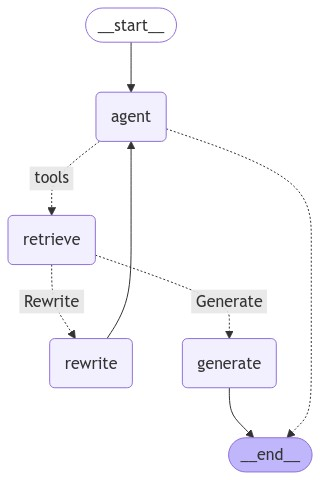

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=5).draw_mermaid_png()))

In [ ]:
import pprint

inputs = {
    "messages": [
        ("user", "What is the weather today ?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

AGENT
[HumanMessage(content='What is the weather today ?', additional_kwargs={}, response_metadata={}, id='0671e364-17fd-493d-ae60-880daa8d75f4')]
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='I am sorry, I cannot provide you with the weather information. I do not have access to real-time data, such as weather conditions. \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-9142d989-8d7b-4fd8-8d84-d76f385b5fb2-0', usage_metadata={'input_tokens': 65, 'output_tokens': 29, 'total_tokens': 94, 'i